# Predictive Inventory Optimization for Supply Chain Efficiency

#### BY SHIVANI UPPALA

In [53]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from scipy import stats  # For any statistical analysis
from statsmodels.tsa.seasonal import seasonal_decompose  # For time series decomposition
from sklearn.metrics import mean_absolute_error, mean_squared_error # Import metrics
import warnings
warnings.filterwarnings('ignore')

In [54]:
 # Load the data
df = pd.read_csv('train.csv')
df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
print("Dataset loaded successfully.")
print(f"Shape: {df.shape}")  # ~913,000 rows, 4 columns

Dataset loaded successfully.
Shape: (913000, 4)


In [55]:
# Basic info and description
print("\nData Info:")
df.info()
print("\nDescriptive Statistics:")
print(df.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB

Descriptive Statistics:
                                date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:0

In [56]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())  # Should be none


Missing Values:
date     0
store    0
item     0
sales    0
dtype: int64


In [57]:
# Cap sales outliers at 99th percentile
sales_cap = df['sales'].quantile(0.99)
df['sales'] = np.where(df['sales'] > sales_cap, sales_cap, df['sales'])
print("Outliers capped.")

Outliers capped.


In [58]:
# Extract date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

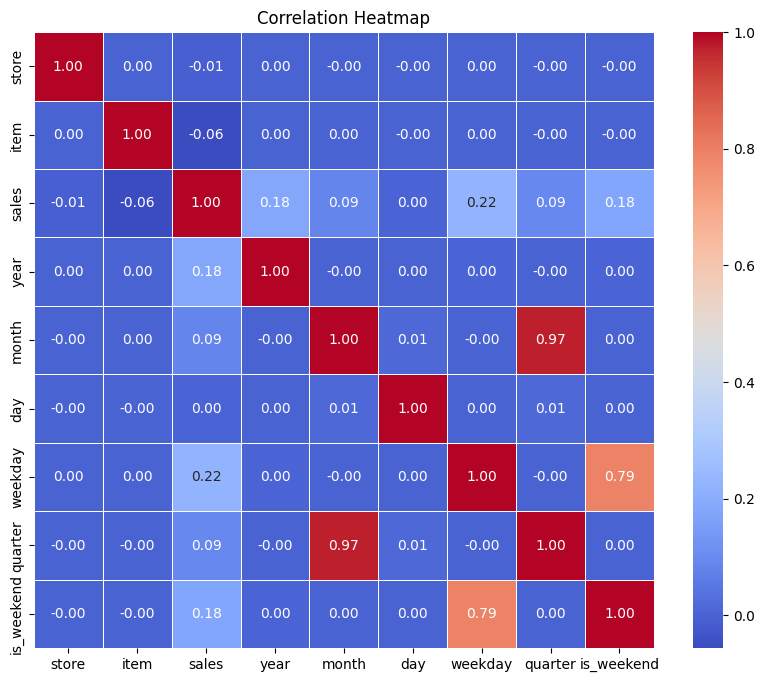

In [59]:
# Select numeric columns
numeric_cols = ['store', 'item', 'sales', 'year', 'month', 'day', 'weekday', 'quarter', 'is_weekend']
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [60]:
# Group and sort averages
avg_sales_store = df.groupby('store')['sales'].mean().sort_values(ascending=False)
avg_sales_item = df.groupby('item')['sales'].mean().sort_values(ascending=False)

# Print averages
print("\nAvg Sales by Store:")
print(avg_sales_store)
print("\nAvg Sales by Item:")
print(avg_sales_item)


Avg Sales by Store:
store
2     66.494644
8     63.798072
3     59.386002
10    58.590110
9     54.994699
4     54.851566
1     47.264973
5     39.770164
6     39.733516
7     36.363735
Name: sales, dtype: float64

Avg Sales by Item:
item
15    86.956407
28    86.792552
13    83.599179
18    83.568894
25    80.241238
45    80.137514
38    80.106298
22    80.085542
36    76.790033
8     76.687404
10    73.108598
11    69.591621
12    69.571303
29    69.564348
33    69.490033
24    66.022508
50    65.856517
35    65.777820
14    58.677656
46    58.637842
31    58.637568
2     58.571194
7     58.530504
6     58.500986
9     51.389869
48    51.352848
43    51.294359
26    47.644085
20    47.515936
32    43.981763
39    43.883406
19    40.355531
30    40.337021
21    40.317087
42    36.688116
3     36.642223
17    32.994852
44    29.398193
49    29.335323
23    29.297864
37    29.258379
40    29.249398
34    25.735761
16    25.656079
27    22.049726
4     22.010241
47    22.003341
41    22

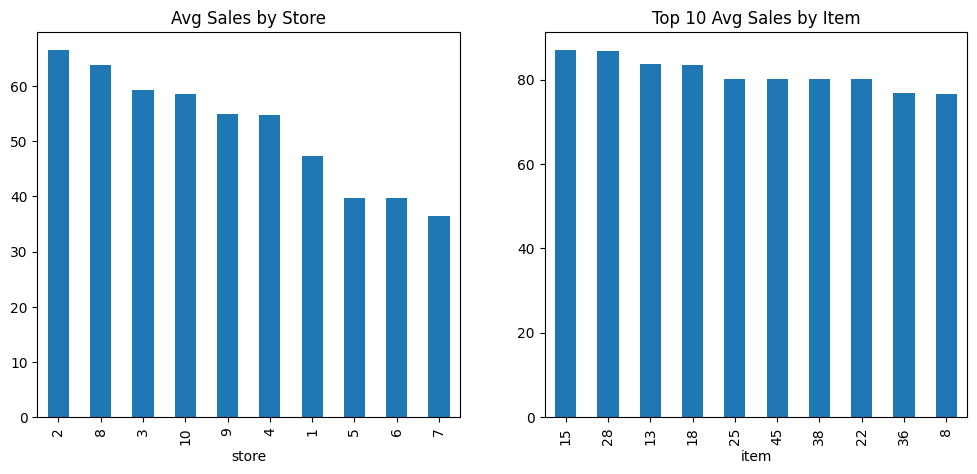

In [61]:
# Plot bar charts
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
avg_sales_store.plot(kind='bar', title='Avg Sales by Store')
plt.subplot(1, 2, 2)
avg_sales_item.head(10).plot(kind='bar', title='Top 10 Avg Sales by Item')
plt.show()

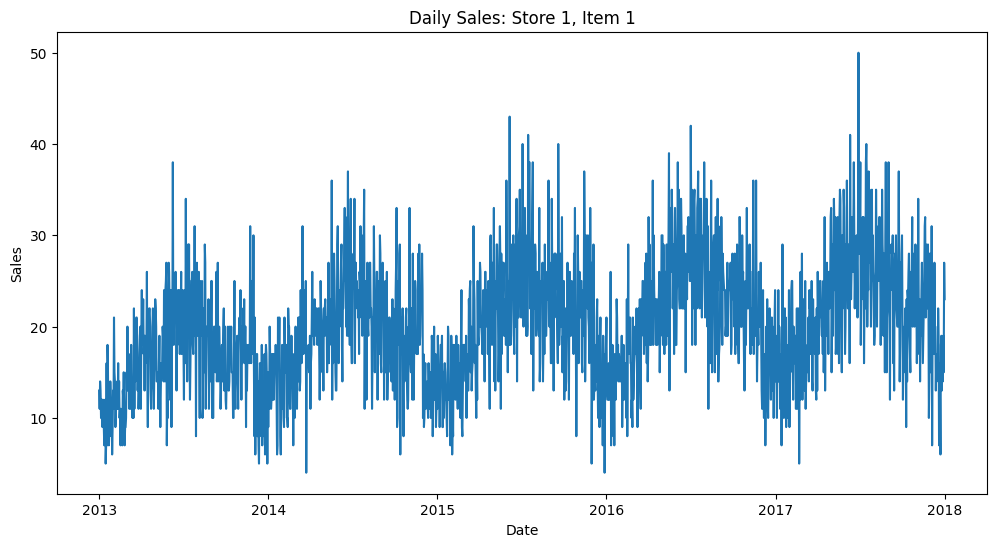

In [62]:
# Filter sample data
sample_df = df[(df['store'] == 1) & (df['item'] == 1)].set_index('date')

# Plot daily sales
plt.figure(figsize=(12, 6))
plt.plot(sample_df['sales'])
plt.title('Daily Sales: Store 1, Item 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

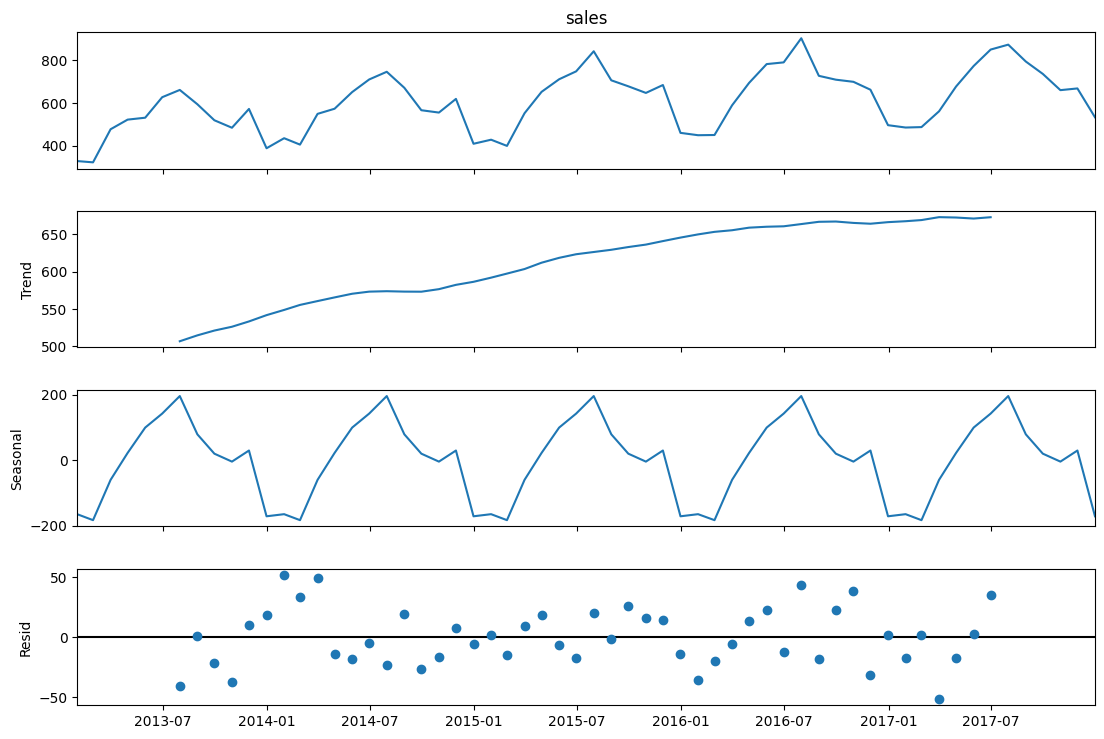

In [63]:
# Resample to monthly
monthly_sales = sample_df['sales'].resample('M').sum()

# Decompose series
decomp = seasonal_decompose(monthly_sales, model='additive')
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()

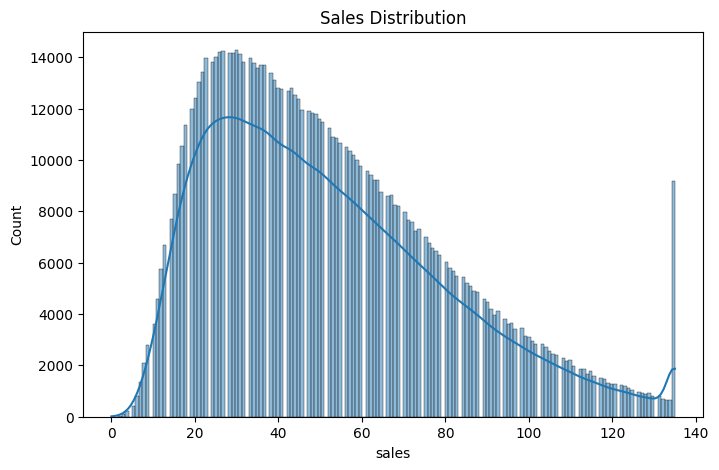

In [64]:
# Plot histogram with KDE
plt.figure(figsize=(8, 5))
sns.histplot(df['sales'], kde=True)
plt.title('Sales Distribution')
plt.show()

In [65]:
# Run Shapiro-Wilk on sample
stat, p = stats.shapiro(df['sales'].sample(1000))
print(f"Shapiro-Wilk: Stat={stat:.2f}, p={p:.4f}")

Shapiro-Wilk: Stat=0.94, p=0.0000


In [66]:
# Calculate Z-scores
df['z_score'] = np.abs(stats.zscore(df['sales']))
outliers = df[df['z_score'] > 3]
print(f"Outliers (Z>3): {len(outliers)}")

Outliers (Z>3): 0


In [67]:
# Split data: last 90 days as test
train_end = sample_df.index.max() - pd.Timedelta(days=90)
train_df = sample_df.loc[:train_end]
test_df = sample_df.loc[train_end + pd.Timedelta(days=1):]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (1736, 9)
Test shape: (90, 9)


In [68]:
# Prepare for Prophet
prophet_df = train_df.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

In [69]:
# Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01bwl9i_/lktjbjpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp01bwl9i_/rwk76qi1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3871', 'data', 'file=/tmp/tmp01bwl9i_/lktjbjpb.json', 'init=/tmp/tmp01bwl9i_/rwk76qi1.json', 'output', 'file=/tmp/tmp01bwl9i_/prophet_modelxj6iv9fd/prophet_model-20250926115212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [70]:
# Forecast for test period
future_test = model.make_future_dataframe(periods=len(test_df), include_history=False)
forecast_test = model.predict(future_test)
forecast_test['ds'] = test_df.index
forecast_test.set_index('ds', inplace=True)

In [71]:
# Evaluate model
mae = mean_absolute_error(test_df['sales'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['sales'], forecast_test['yhat']))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 3.76, RMSE: 4.57


<Figure size 1200x600 with 0 Axes>

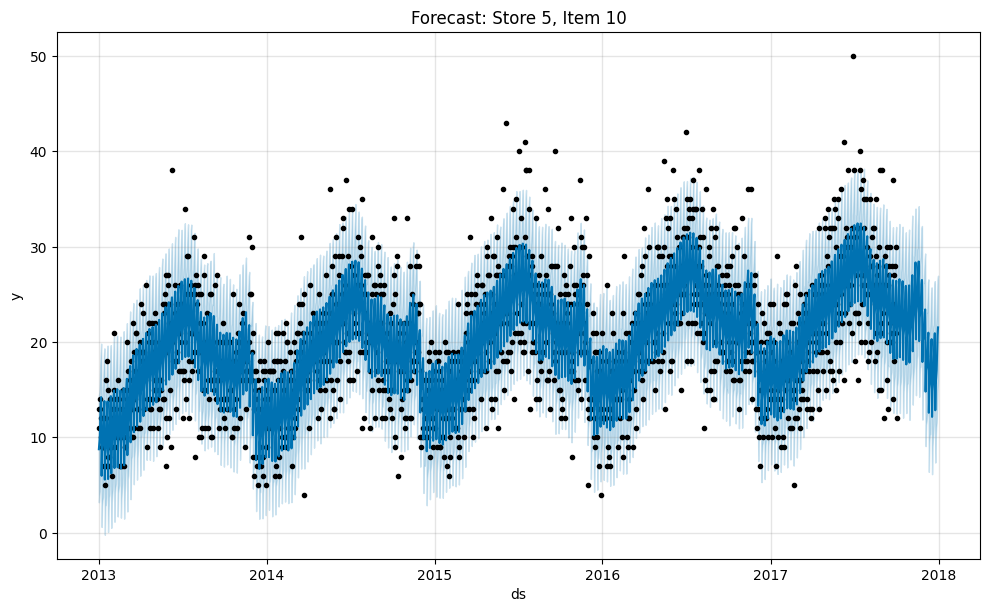

In [72]:
# Forecast next 90 days
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title('Forecast: Store 5, Item 10')
plt.show()

In [73]:
# Inventory optimization
historical_std = sample_df['sales'].std()
avg_demand = sample_df['sales'].mean()
forecast_demand = forecast['yhat'].tail(90).mean()
safety_stock = 1.65 * historical_std * np.sqrt(7)  # 95% service level, 7-day lead time
reorder_point = (forecast_demand * 7) + safety_stock
eoq = np.sqrt(2 * (forecast_demand * 365) * 100 / 1)  # Order cost=100, holding cost=1
print(f"\nOptimization: Avg Demand={forecast_demand:.2f}, Safety Stock={safety_stock:.2f}")
print(f"Reorder Point={reorder_point:.2f}, EOQ={eoq:.2f}")


Optimization: Avg Demand=21.24, Safety Stock=29.43
Reorder Point=178.09, EOQ=1245.13
